<a href="https://colab.research.google.com/github/agenorrneto/pandemia_recife/blob/main/pandemic_at_recife.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Análise de dados referentes a pandemia na cidade do Recife, Pernambuco, Brasil


###Média movel de casos positivos, óbitos e casos graves confirmados

Importando pacotes necessários para a análise

In [1]:
!pip install geopandas

     |████████████████████████████████| 1.0 MB 7.2 MB/s 
     |████████████████████████████████| 6.3 MB 26.5 MB/s 
     |████████████████████████████████| 15.4 MB 25.3 MB/s 


In [2]:
!pip install statsmodels

In [3]:
!pip install unidecode

     |████████████████████████████████| 235 kB 6.7 MB/s 


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib.transforms as mtransforms
from matplotlib import cm
from matplotlib.colors import Normalize
import geopandas as gpd
import unidecode

Recuperando os dados a partir da base de dados da prefeitura

In [5]:
#url = "http://dados.recife.pe.gov.br/dataset/2b5ee58d-9535-4d80-ab32-f63fd475346e/resource/93f4e8c2-430f-4142-86b3-96dab4905b4e/download/casosgravescovid.csv"

graves = pd.read_csv("casosgravescovid.csv", sep=';')

É necessário utilizar apenas as *rows* de casos do município onde possamos saber o bairro. Primeiro podemos checar se existem casos de notificação feita em outro município. Depois disso, podemos excluir essas rows que são de outros municípios. 

In [6]:
graves[(graves['municipio_notificacao'] != "Recife") & (graves['municipio_notificacao'] != "RECIFE")]

,data_notificacao,sexo,idade,data_inicio_sintomas,raca,etnia,sintomas_apresentados,outros_sintomas,doencas_preexistentes,outras_doencas_preexistentes,evolucao,classificacao_final,data_obito,profissional_saude,categoria_profissional,municipio_notificacao,bairro,ds
10120,2021-09-25,Feminino,75,2021-09-20,Ignorado,NaN,"Tosse, Dispneia, Cansaço/fadiga, Náusea, Satur...",NaN,"Doenças Cardíacas ou Vasculares, Diabetes",AVC,INTERNADO LEITO DE ISOLAMENTO,EM ANÁLISE,NaN,NÃO,NaN,GOIANA,IGN,IGN
23704,2021-09-22,Feminino,50,2021-09-02,Parda,NaN,"Tosse, Dispneia, Saturação O2 < 95",NaN,NaN,DPOC,INTERNADO LEITO DE ISOLAMENTO,EM ANÁLISE,NaN,NÃO,NaN,Jaboatao dos Guararapes,IGN,IGN
27342,2021-09-23,Feminino,27,2021-09-22,Ignorado,NaN,Dispneia,NaN,NaN,HIV,INTERNADO UTI,EM ANÁLISE,NaN,NÃO,NaN,JABOATAO,IGN,IGN
30737,2021-09-24,Feminino,6 meses,2021-09-20,Parda,NaN,"Febre, Tosse, Dispneia, Desconforto respiratór...",NaN,NaN,NaN,INTERNADO LEITO DE ISOLAMENTO,EM ANÁLISE,NaN,NÃO,NaN,JABOATÃO,IGN,IGN
30738,2021-09-24,Masculino,4 meses,2021-09-17,Parda,NaN,"Febre, Tosse, Dispneia, Desconforto respiratór...",NaN,NaN,NaN,INTERNADO LEITO DE ISOLAMENTO,EM ANÁLISE,NaN,NÃO,NaN,IPOJUCA,IGN,IGN


In [7]:
to_drop = graves[(graves['municipio_notificacao'] != "Recife") & (graves['municipio_notificacao'] != "RECIFE")].index
graves.drop(to_drop, axis=0, inplace=True)

Excluidos essas linhas indesejadas, vamos checar os bairros desses casos notificados no município do Recife. Feito isso, podemos ver que alguns estão em caixa alta e outros, não. É importante normalizar esse dados de modo que dois bairros não sejam contados duas vezes. Fazemos isso também para o município de notificação.

In [8]:
graves.bairro.unique()

array(['PASSARINHO', 'BOA VIAGEM', 'DOIS UNIDOS', 'NOVA DESCOBERTA',
       'IPUTINGA', 'MACAXEIRA', 'IBURA', 'AREIAS', 'IGN', 'AFOGADOS',
       'TORROES', 'JORDAO', 'ALTO DO MANDU', 'ILHA JOANA BEZERRA',
       'IMBIRIBEIRA', 'CAXANGA', 'BARRO', 'GRACAS', 'MUSTARDINHA',
       'SANTO AMARO', 'COHAB', 'LINHA DO TIRO', 'CAMPO GRANDE',
       'ESTANCIA', 'FUNDAO', 'GUABIRABA', 'ESPINHEIRO', 'ZUMBI',
       'JARDIM SAO PAULO', 'AGUA FRIA', 'BONGI', 'VARZEA', 'MANGABEIRA',
       'TORRE', 'CASA AMARELA', 'IPSEP', 'CAMPINA DO BARRETO', 'MADALENA',
       'CAJUEIRO', 'DERBY', 'MANGUEIRA', 'BRASILIA TEIMOSA', 'PINA',
       'PRADO', 'BOA VISTA', 'ALTO SANTA TEREZINHA', 'BREJO DE BEBERIBE',
       'ALTO JOSE BONIFACIO', 'VASCO DA GAMA', 'PEIXINHOS', 'CORDEIRO',
       'SAN MARTIN', 'BREJO DA GUABIRABA', 'MORRO DA CONCEICAO',
       'SAO JOSE', 'POCO', 'CASA FORTE', 'TAMARINEIRA',
       'ALTO JOSE DO PINHO', 'BOMBA DO HEMETERIO', 'TEJIPIO',
       'CORREGO DO JENIPAPO', 'ARRUDA', 'AFLITOS', '

In [9]:
def upper_cell(item):
  return item.upper()

In [10]:
graves['municipio_notificacao'] = graves['municipio_notificacao'].map(upper_cell)

In [11]:
graves.bairro.unique()

array(['PASSARINHO', 'BOA VIAGEM', 'DOIS UNIDOS', 'NOVA DESCOBERTA',
       'IPUTINGA', 'MACAXEIRA', 'IBURA', 'AREIAS', 'IGN', 'AFOGADOS',
       'TORROES', 'JORDAO', 'ALTO DO MANDU', 'ILHA JOANA BEZERRA',
       'IMBIRIBEIRA', 'CAXANGA', 'BARRO', 'GRACAS', 'MUSTARDINHA',
       'SANTO AMARO', 'COHAB', 'LINHA DO TIRO', 'CAMPO GRANDE',
       'ESTANCIA', 'FUNDAO', 'GUABIRABA', 'ESPINHEIRO', 'ZUMBI',
       'JARDIM SAO PAULO', 'AGUA FRIA', 'BONGI', 'VARZEA', 'MANGABEIRA',
       'TORRE', 'CASA AMARELA', 'IPSEP', 'CAMPINA DO BARRETO', 'MADALENA',
       'CAJUEIRO', 'DERBY', 'MANGUEIRA', 'BRASILIA TEIMOSA', 'PINA',
       'PRADO', 'BOA VISTA', 'ALTO SANTA TEREZINHA', 'BREJO DE BEBERIBE',
       'ALTO JOSE BONIFACIO', 'VASCO DA GAMA', 'PEIXINHOS', 'CORDEIRO',
       'SAN MARTIN', 'BREJO DA GUABIRABA', 'MORRO DA CONCEICAO',
       'SAO JOSE', 'POCO', 'CASA FORTE', 'TAMARINEIRA',
       'ALTO JOSE DO PINHO', 'BOMBA DO HEMETERIO', 'TEJIPIO',
       'CORREGO DO JENIPAPO', 'ARRUDA', 'AFLITOS', '

In [12]:
graves['bairro'] = graves['bairro'].map(upper_cell)

In [13]:
graves.bairro.value_counts()

BOA VIAGEM         2668
VARZEA             1191
IBURA              1171
IPUTINGA            994
COHAB               954
                   ... 
PEIXINHOS            38
PONTO DE PARADA      37
RECIFE               36
CABANGA              34
PAU FERRO             1
Name: bairro, Length: 95, dtype: int64

A coluna data_notificação não está no seu data_type correto. É preciso convertê-la.

In [14]:
graves.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30735 entries, 0 to 30739
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   data_notificacao              30735 non-null  object
 1   sexo                          30735 non-null  object
 2   idade                         30735 non-null  object
 3   data_inicio_sintomas          29703 non-null  object
 4   raca                          24404 non-null  object
 5   etnia                         3 non-null      object
 6   sintomas_apresentados         28810 non-null  object
 7   outros_sintomas               5005 non-null   object
 8   doencas_preexistentes         10761 non-null  object
 9   outras_doencas_preexistentes  6088 non-null   object
 10  evolucao                      29898 non-null  object
 11  classificacao_final           30735 non-null  object
 12  data_obito                    7732 non-null   object
 13  profissional_sau

In [15]:
graves['data_notificacao'] = pd.to_datetime(graves['data_notificacao'], format="%Y/%m/%d")

In [16]:
graves.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30735 entries, 0 to 30739
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   data_notificacao              30735 non-null  datetime64[ns]
 1   sexo                          30735 non-null  object        
 2   idade                         30735 non-null  object        
 3   data_inicio_sintomas          29703 non-null  object        
 4   raca                          24404 non-null  object        
 5   etnia                         3 non-null      object        
 6   sintomas_apresentados         28810 non-null  object        
 7   outros_sintomas               5005 non-null   object        
 8   doencas_preexistentes         10761 non-null  object        
 9   outras_doencas_preexistentes  6088 non-null   object        
 10  evolucao                      29898 non-null  object        
 11  classificacao_final         

In [17]:
graves['data_notificacao'].value_counts()

2020-04-23    464
2020-04-13    405
2020-05-11    373
2020-04-14    346
2020-04-22    333
             ... 
2020-03-01      1
2020-03-06      1
2020-02-29      1
2020-03-02      1
2020-03-09      1
Name: data_notificacao, Length: 576, dtype: int64

In [18]:
graves = graves[graves['classificacao_final'] == 'CONFIRMADO'] #Somente casos graves confirmados para SARS-CoV-2

In [19]:
graves

,data_notificacao,sexo,idade,data_inicio_sintomas,raca,etnia,sintomas_apresentados,outros_sintomas,doencas_preexistentes,outras_doencas_preexistentes,evolucao,classificacao_final,data_obito,profissional_saude,categoria_profissional,municipio_notificacao,bairro,ds
2,2021-01-08,Masculino,78,2021-01-06,Branca,NaN,"Tosse, Dispneia, Dor de Garganta, Cansaço/fadi...",NaN,"Doenças Cardíacas ou Vasculares, Doença Hepáti...",NaN,ÓBITO,CONFIRMADO,2021-01-26,NÃO,NaN,RECIFE,BOA VIAGEM,VI
7,2021-01-22,Feminino,34,2021-01-12,Branca,NaN,"Febre, Tosse, Dor de Garganta, Desconforto res...",NaN,Sobrepeso/Obesidade,NaN,RECUPERADO,CONFIRMADO,NaN,NÃO,NaN,RECIFE,IBURA,VIII
8,2021-02-12,Masculino,61,2021-02-01,Ignorado,NaN,"Tosse, Dispneia, Mialgia, Saturação O2 < 95",NaN,NaN,NaN,RECUPERADO,CONFIRMADO,NaN,NÃO,NaN,RECIFE,AREIAS,V
9,2021-01-25,Masculino,59,2021-01-22,Branca,NaN,"Tosse, Dispneia, Desconforto respiratório / ap...",NaN,Imunossupressão,NaN,RECUPERADO,CONFIRMADO,NaN,NÃO,NaN,RECIFE,IGN,IGN
12,2021-02-15,Masculino,69,2021-02-10,Parda,NaN,"Febre, Tosse, Dispneia, Saturação O2 < 95",SOLUÇÃO,Doenças Respiratórias Crônicas,NaN,RECUPERADO,CONFIRMADO,NaN,NÃO,NaN,RECIFE,JORDAO,VIII
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30714,2021-06-08,Masculino,61,2021-06-03,Ignorado,NaN,"Febre, Tosse, Dispneia, Alteração/perda de olf...",NaN,"Doenças Cardíacas ou Vasculares, Diabetes",NaN,RECUPERADO,CONFIRMADO,NaN,NÃO,NaN,RECIFE,SAN MARTIN,V
30718,2021-07-19,Masculino,81,2021-07-16,Ignorado,NaN,"Febre, Dispneia, Mialgia, Saturação O2 < 95",NaN,"Diabetes, Sobrepeso/Obesidade, Doenças Cardíac...",NaN,ÓBITO,CONFIRMADO,2021-09-12,NÃO,NaN,RECIFE,TORROES,IV
30720,2021-01-03,Masculino,83,2020-12-31,Preta,NaN,"Tosse, Desconforto respiratório / aperto torác...",NaN,"Doenças Cardíacas ou Vasculares, Doenças Respi...",DPOC,ÓBITO,CONFIRMADO,2021-01-07,NÃO,NaN,RECIFE,IMBIRIBEIRA,VI
30724,2021-09-18,Masculino,16,2021-09-10,Parda,NaN,"Febre, Tosse, Dispneia, Desconforto respiratór...",NaN,NaN,PORTADOR DE PARALISIA CEREBRAL + EPILEPTICO,INTERNADO UTI,CONFIRMADO,NaN,NÃO,NaN,RECIFE,SANTANA,III


Agora, com o formato correto, ordenamos os dados numa escala temporal, contamos os valores de cada data e criamos outros dataframe de forma a ter um datafram pronto para ser "plotado".

In [20]:
graves.sort_values(by="data_notificacao", inplace=True)
graves_cont = pd.DataFrame(graves['data_notificacao'].value_counts())
graves_cont.sort_index(inplace=True)
graves_cont.rename(columns={'data_notificacao':'casos'}, inplace=True)

In [21]:
graves_cont

,casos
2020-03-05,2
2020-03-07,1
2020-03-12,7
2020-03-13,5
2020-03-14,1
...,...
2021-09-20,7
2021-09-21,7
2021-09-22,6
2021-09-23,2


In [22]:
graves_cont.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 560 entries, 2020-03-05 to 2021-09-24
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   casos   560 non-null    int64
dtypes: int64(1)
memory usage: 8.8 KB


Existe um dataset oficial, atualizado diariamente. Com ele, posso ver os dados do dia. Entretanto, como a página da prefeitura não está no mesmo ritmo de atualização, tenho de setar dias para fazer a análise.

No dia 2021-10-04, temos esses dados para Recife.

In [23]:
url = "https://github.com/wcota/covid19br/raw/master/cases-brazil-cities-time.csv.gz"
total_cases = pd.read_csv(url, compression='gzip')

In [24]:
total_cases_recife = total_cases[total_cases['city'] == "Recife/PE"]

In [25]:
total_cases_recife

,epi_week,date,country,state,city,ibgeID,newDeaths,deaths,newCases,totalCases,deaths_per_100k_inhabitants,totalCases_per_100k_inhabitants,deaths_by_totalCases,_source,last_info_date
105,11,2020-03-12,Brazil,PE,Recife/PE,2611606,0,0,2,2,0.00000,0.12041,0.00000,SES,2021-10-22
132,11,2020-03-13,Brazil,PE,Recife/PE,2611606,0,0,0,2,0.00000,0.12041,0.00000,SES,2021-10-22
168,11,2020-03-14,Brazil,PE,Recife/PE,2611606,0,0,4,6,0.00000,0.36122,0.00000,SES,2021-10-22
204,12,2020-03-15,Brazil,PE,Recife/PE,2611606,0,0,1,7,0.00000,0.42143,0.00000,SES,2021-10-22
246,12,2020-03-16,Brazil,PE,Recife/PE,2611606,0,0,0,7,0.00000,0.42143,0.00000,SES,2021-10-22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3193364,148,2021-12-02,Brazil,PE,Recife/PE,2611606,1,5630,45,160959,338.94897,9690.38848,0.03498,MS,2021-12-06
3198961,148,2021-12-03,Brazil,PE,Recife/PE,2611606,3,5633,43,161002,339.12958,9692.97725,0.03499,MS,2021-12-06
3204558,148,2021-12-04,Brazil,PE,Recife/PE,2611606,2,5635,22,161024,339.24999,9694.30174,0.03499,MS,2021-12-06
3210155,149,2021-12-05,Brazil,PE,Recife/PE,2611606,2,5637,66,161090,339.37040,9698.27521,0.03499,MS,2021-12-06


In [26]:
total_cases_recife["date"] =  pd.to_datetime(total_cases_recife["date"], format= "%Y/%m/%d")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [27]:
total_cases_recife.set_index(total_cases_recife['date'], inplace=True)

In [28]:
total_cases_recife

,epi_week,date,country,state,city,ibgeID,newDeaths,deaths,newCases,totalCases,deaths_per_100k_inhabitants,totalCases_per_100k_inhabitants,deaths_by_totalCases,_source,last_info_date
date,,,,,,,,,,,,,,,
2020-03-12,11,2020-03-12,Brazil,PE,Recife/PE,2611606,0,0,2,2,0.00000,0.12041,0.00000,SES,2021-10-22
2020-03-13,11,2020-03-13,Brazil,PE,Recife/PE,2611606,0,0,0,2,0.00000,0.12041,0.00000,SES,2021-10-22
2020-03-14,11,2020-03-14,Brazil,PE,Recife/PE,2611606,0,0,4,6,0.00000,0.36122,0.00000,SES,2021-10-22
2020-03-15,12,2020-03-15,Brazil,PE,Recife/PE,2611606,0,0,1,7,0.00000,0.42143,0.00000,SES,2021-10-22
2020-03-16,12,2020-03-16,Brazil,PE,Recife/PE,2611606,0,0,0,7,0.00000,0.42143,0.00000,SES,2021-10-22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-02,148,2021-12-02,Brazil,PE,Recife/PE,2611606,1,5630,45,160959,338.94897,9690.38848,0.03498,MS,2021-12-06
2021-12-03,148,2021-12-03,Brazil,PE,Recife/PE,2611606,3,5633,43,161002,339.12958,9692.97725,0.03499,MS,2021-12-06
2021-12-04,148,2021-12-04,Brazil,PE,Recife/PE,2611606,2,5635,22,161024,339.24999,9694.30174,0.03499,MS,2021-12-06


In [29]:
total_cases_recife.loc['2020-03-12':'2020-07-12'] #34,97% dos óbitos totais da cidade

,epi_week,date,country,state,city,ibgeID,newDeaths,deaths,newCases,totalCases,deaths_per_100k_inhabitants,totalCases_per_100k_inhabitants,deaths_by_totalCases,_source,last_info_date
date,,,,,,,,,,,,,,,
2020-03-12,11,2020-03-12,Brazil,PE,Recife/PE,2611606,0,0,2,2,0.00000,0.12041,0.00000,SES,2021-10-22
2020-03-13,11,2020-03-13,Brazil,PE,Recife/PE,2611606,0,0,0,2,0.00000,0.12041,0.00000,SES,2021-10-22
2020-03-14,11,2020-03-14,Brazil,PE,Recife/PE,2611606,0,0,4,6,0.00000,0.36122,0.00000,SES,2021-10-22
2020-03-15,12,2020-03-15,Brazil,PE,Recife/PE,2611606,0,0,1,7,0.00000,0.42143,0.00000,SES,2021-10-22
2020-03-16,12,2020-03-16,Brazil,PE,Recife/PE,2611606,0,0,0,7,0.00000,0.42143,0.00000,SES,2021-10-22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-07-08,28,2020-07-08,Brazil,PE,Recife/PE,2611606,3,1927,253,22092,116.01326,1330.02853,0.08723,SES,2021-10-22
2020-07-09,28,2020-07-09,Brazil,PE,Recife/PE,2611606,19,1946,206,22298,117.15714,1342.43057,0.08727,SES,2021-10-22
2020-07-10,28,2020-07-10,Brazil,PE,Recife/PE,2611606,8,1954,215,22513,117.63877,1355.37445,0.08679,SES,2021-10-22


In [30]:
total_cases_recife.loc['2020-11-01':'2021-06-30'] #37,76% dos óbitos totais da cidade

,epi_week,date,country,state,city,ibgeID,newDeaths,deaths,newCases,totalCases,deaths_per_100k_inhabitants,totalCases_per_100k_inhabitants,deaths_by_totalCases,_source,last_info_date
date,,,,,,,,,,,,,,,
2020-11-01,45,2020-11-01,Brazil,PE,Recife/PE,2611606,0,2458,-64,36666,147.98163,2207.44279,0.06704,SES,2021-10-22
2020-11-02,45,2020-11-02,Brazil,PE,Recife/PE,2611606,0,2458,22,36688,147.98163,2208.76728,0.06700,SES,2021-10-22
2020-11-03,45,2020-11-03,Brazil,PE,Recife/PE,2611606,1,2459,13,36701,148.04183,2209.54993,0.06700,SES,2021-10-22
2020-11-04,45,2020-11-04,Brazil,PE,Recife/PE,2611606,10,2469,77,36778,148.64387,2214.18565,0.06713,SES,2021-10-22
2020-11-05,45,2020-11-05,Brazil,PE,Recife/PE,2611606,4,2473,118,36896,148.88469,2221.28973,0.06703,SES,2021-10-22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-26,125,2021-06-26,Brazil,PE,Recife/PE,2611606,0,4639,310,134080,279.28673,8072.16302,0.03460,SES,2021-10-22
2021-06-27,126,2021-06-27,Brazil,PE,Recife/PE,2611606,7,4646,271,134351,279.70815,8088.47832,0.03458,SES,2021-10-22
2021-06-28,126,2021-06-28,Brazil,PE,Recife/PE,2611606,3,4649,191,134542,279.88877,8099.97730,0.03455,SES,2021-10-22


In [31]:
total_cases_recife.newCases.rolling(7).mean().loc["2021-01-18"]

245.71428571428572

In [32]:
total_cases_recife.index

DatetimeIndex(['2020-03-12', '2020-03-13', '2020-03-14', '2020-03-15',
               '2020-03-16', '2020-03-17', '2020-03-18', '2020-03-19',
               '2020-03-20', '2020-03-21',
               ...
               '2021-11-27', '2021-11-28', '2021-11-29', '2021-11-30',
               '2021-12-01', '2021-12-02', '2021-12-03', '2021-12-04',
               '2021-12-05', '2021-12-06'],
              dtype='datetime64[ns]', name='date', length=635, freq=None)

In [33]:
total_cases_recife.loc['2020-03-12':'2021-09-15'].newDeaths.rolling(7).mean()

date
2020-03-12         NaN
2020-03-13         NaN
2020-03-14         NaN
2020-03-15         NaN
2020-03-16         NaN
                ...   
2021-09-11    5.428571
2021-09-12    4.857143
2021-09-13    5.142857
2021-09-14    4.714286
2021-09-15    5.000000
Name: newDeaths, Length: 553, dtype: float64

In [34]:
def add_innerbox(ax, text):
  ax.text(.90, .8, text,
          horizontalalignment='center',
          transform=ax.transAxes,
          bbox=dict(facecolor='white', alpha=0.6),
          fontsize=12.5)

In [35]:
from datetime import datetime
dates = ['2020-03-12', '2020-12-31']
dates = [datetime.strptime(x, '%Y-%m-%d') for x in dates]

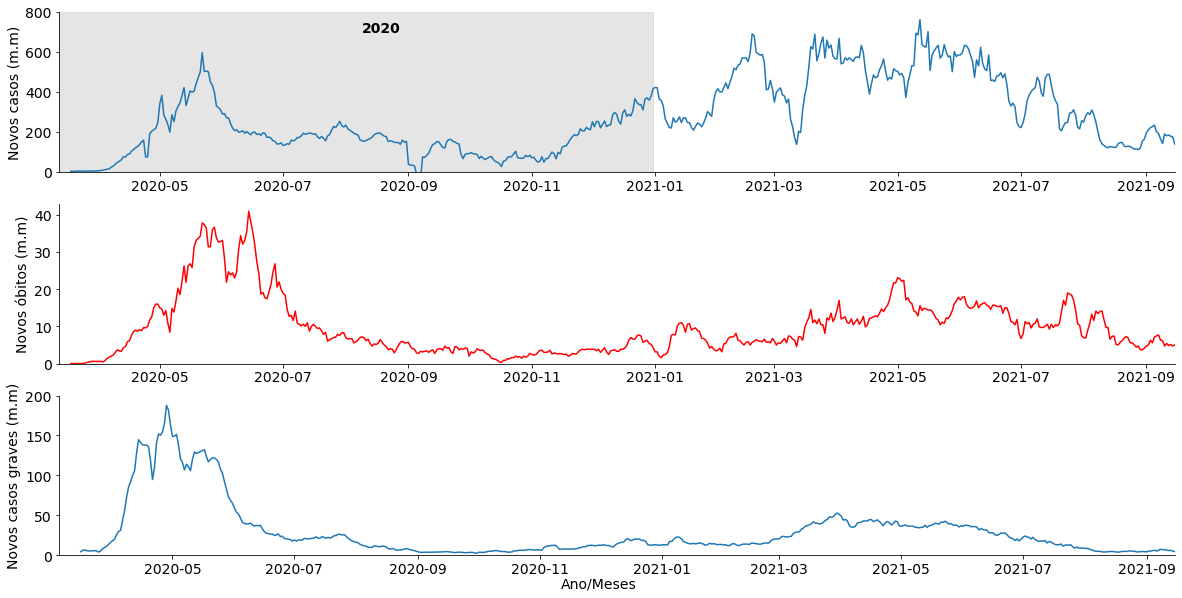

In [42]:

fig, (ax1,ax2,ax3) = plt.subplots(nrows=3, figsize=(20, 10))

plt.rcParams.update({'font.size': 14})

#remove axes spines
for s in ['top', 'right']:
    ax1.spines[s].set_visible(False)
    ax2.spines[s].set_visible(False)
    ax3.spines[s].set_visible(False)


ax1.plot(total_cases_recife.loc['2020-03-12':'2021-09-15'].newCases.rolling(7).mean()) #ma de novos casos
ax1.set_xlim(xmin=total_cases_recife.loc['2020-03-12':'2021-09-15'].newCases.rolling(7).mean().index[0], 
             xmax=total_cases_recife.loc['2020-03-12':'2021-09-15'].newCases.rolling(7).mean().index[-1]) 
ax1.set_ylim(0)
ax1.set_ylabel("Novos casos (m.m)")


ax2.plot(total_cases_recife.loc['2020-03-12':'2021-09-15'].newDeaths.rolling(7).mean(), color = "r", linestyle='solid') #ma de óbitos
ax2.set_xlim(xmin=total_cases_recife.loc['2020-03-12':'2021-09-15'].newDeaths.rolling(7).mean().index[0], 
             xmax=total_cases_recife.loc['2020-03-12':'2021-09-15'].newDeaths.rolling(7).mean().index[-1])
ax2.set_ylim(0)
ax2.set_ylabel("Novos óbitos (m.m)")


ax3.plot(graves_cont.loc['2020-03-05':'2021-09-15'].rolling(7).mean()) #ma de casos de SRAG
ax3.set_xlim(xmin=graves_cont.loc['2020-03-05':'2021-09-15'].rolling(7).mean().index[0], 
             xmax=graves_cont.loc['2020-03-05':'2021-09-15'].rolling(7).mean().index[-1])
ax3.set_ylim(0, 200)
ax3.set_ylabel("Novos casos graves (m.m)")

#16 a 31 maio 2020, restrição de pessoas no Recife
#15th march, schools get back
#18th january, vaccination begins

fig.text(0.5, 0.08, "Ano/Meses", ha="center")
#add_innerbox(ax1, "Novos casos (m.m)")
#add_innerbox(ax2, "Novos óbitos (m.m)")
#add_innerbox(ax3, "Novos casos graves (m.m)")

#1st lockdown
ax1.axvspan(dates[0], dates[1], alpha=0.2, color="gray")
ax1.text(total_cases_recife.loc['2020-03-12':'2021-09-15'].newCases.rolling(7).mean().index[150], 700, s="2020", weight='bold')

#vaccination
#vac = ax1.plot(datetime.strptime('2021-01-18', '%Y-%m-%d'), total_cases_recife.newCases.rolling(7).mean().loc['2021-01-18'], '*', color='r')
#ax1.legend((vac), ("vaccination",), loc="upper left")

fig.show()
#Covid-19 confirmado e não confirmados para nenhuma outra coisa

#segunda onda! = lockdown março, édia sustentada de mortes

##Montando o ambiente para uma análise espacial

In [76]:
bairros_json = gpd.read_file("/content/bairros.geojson")

In [77]:
bairros_json[bairros_json['bairro_nome_ca'] == 'PAU FERRO']

,bairro_codigo,bairro_nome_ca,rpa,microrregiao,bairro_nome,geometry
27,639,PAU FERRO,3,3,Pau Ferro,"POLYGON ((-34.99012 -7.96201, -34.99012 -7.962..."


In [78]:
bairros_json.rename(columns={'bairro_nome_ca': 'bairro'}, inplace=True)

In [79]:
bairros_pop = pd.read_csv("/content/bairros_recife_populacao.csv", thousands='.')

In [80]:
bairros_pop

,bairro,pop
0,Aflitos,5773
1,Afogados,36265
2,Água Fria,43529
3,Alto do Mandu,4655
4,Alto José Bonifácio,12462
...,...,...
89,Torrões,32015
90,Totó,2420
91,Várzea,70453
92,Vasco da Gama,31025


In [81]:
bairros_pop['bairro'] = bairros_pop['bairro'].map(upper_cell)

In [82]:
bairros_pop

,bairro,pop
0,AFLITOS,5773
1,AFOGADOS,36265
2,ÁGUA FRIA,43529
3,ALTO DO MANDU,4655
4,ALTO JOSÉ BONIFÁCIO,12462
...,...,...
89,TORRÕES,32015
90,TOTÓ,2420
91,VÁRZEA,70453
92,VASCO DA GAMA,31025


In [83]:
bairro_sem_acento = []
for idx in range(len(bairros_pop)):
  bairro_sem_acento.append(unidecode.unidecode(bairros_pop.iloc[idx]['bairro']))

bairros_pop['bairro'] = bairro_sem_acento

In [84]:
bairros_pop.sort_values(by=['pop'])

,bairro,pop
68,PAU FERRO,72
81,SANTO ANTONIO,285
65,PAISSANDU,507
75,RECIFE,602
27,CIDADE UNIVERSITARIA,818
...,...,...
45,IBURA,50617
51,IPUTINGA,52200
29,COHAB,67283
91,VARZEA,70453


In [85]:
bairros_json = pd.merge(bairros_json, bairros_pop, on=['bairro'], how='outer')

In [86]:
bairros_json

,bairro_codigo,bairro,rpa,microrregiao,bairro_nome,geometry,pop
0,728,CIDADE UNIVERSITARIA,4,3,Cidade Universitária,"POLYGON ((-34.94416 -8.04985, -34.94419 -8.050...",818
1,116,SOLEDADE,1,2,Soledade,"POLYGON ((-34.88631 -8.05667, -34.88697 -8.057...",2495
2,710,ENGENHO DO MEIO,4,2,Engenho do Meio,"POLYGON ((-34.93946 -8.04985, -34.93920 -8.050...",10211
3,841,CACOTE,5,2,Caçote,"POLYGON ((-34.92839 -8.09840, -34.92817 -8.099...",10470
4,884,COHAB,6,3,Cohab,"POLYGON ((-34.94679 -8.10944, -34.94651 -8.110...",67283
...,...,...,...,...,...,...,...
89,825,JIQUIA,5,2,Jiquiá,"POLYGON ((-34.93468 -8.07772, -34.93166 -8.075...",10245
90,779,AFOGADOS,5,3,Afogados,"MULTIPOLYGON (((-34.91209 -8.06406, -34.91207 ...",36265
91,507,APIPUCOS,3,1,Apipucos,"POLYGON ((-34.93551 -8.01031, -34.93551 -8.010...",3342
92,418,GUABIRABA,3,3,Guabiraba,"POLYGON ((-35.00157 -7.92781, -35.00148 -7.927...",6330


##Casos PCR positivos: visão temporal e espacial

In [129]:
leves = "http://dados.recife.pe.gov.br/dataset/35b7d449-f2f5-4d90-a1ed-6d2a23462bc8/resource/8d275f9b-854e-4d9d-9f50-ada414e29e2f/download/casoslevescovid.csv"

casos_leves = pd.read_csv(leves, sep=';')

casos_leves

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (1,10) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,sexo,idade,data_notificacao,data_inicio_sintomas,sintomas,outros_sintomas,evolucao_caso,em_tratamento_domiciliar,doencas_preexistentes,raca_cor,etnia,profissional_saude,cbo,municipio_notificacao,bairro,ds
0,Masculino,59,2020-03-30,2020-03-29,"Dor De Garganta,Tosse,",0,NaN,NaN,NaN,NaN,NaN,Não,NaN,NaN,IPUTINGA,IV
1,Feminino,44,2020-03-24,2020-03-03,"Febre,Tosse,",0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Fortaleza,IGNORADO,IGNORADO
2,Feminino,25,2020-03-23,2020-03-16,"Febre, Tosse,","Mialgia,Artralgia, Coriza, Calafrios, Producao...",NaN,NaN,NaN,NaN,NaN,Sim,NaN,Sao Luis,IGNORADO,IGNORADO
3,Feminino,5,2020-03-06,2020-02-28,"Febre , Tosse , Dor De Garganta",0,Cura,Descartado,NaN,NaN,NaN,NaN,NaN,Recife,IGNORADO,IGNORADO
4,Feminino,IGN,2020-03-07,2020-02-25,"Febre , Tosse ,",Coriza,Cura,Descartado,NaN,NaN,NaN,NaN,NaN,Recife,IGNORADO,IGNORADO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
574287,Feminino,29,2021-05-02,2021-04-30,"Outros, Assintomático",0,Cura,Descartado,NaN,Parda,NaN,Não,NaN,Recife,PASSARINHO,VII
574288,Feminino,48,2021-05-02,2021-04-25,"Tosse, Dor de Cabeça",PRE OPERATORIO,Cura,Descartado,NaN,Parda,NaN,Não,NaN,Carpina,JARDIM SAO PAULO,V
574289,Feminino,35,2021-05-02,2021-04-30,"Outros, Assintomático",0,Cura,Descartado,NaN,Parda,NaN,Não,NaN,Recife,VARZEA,IV
574290,Masculino,71,2021-05-02,2021-04-30,"Outros, Assintomático",PRE OPERATORIO,Cura,Descartado,NaN,Parda,NaN,Não,NaN,Recife,MUSTARDINHA,V


In [130]:
casos_leves.em_tratamento_domiciliar.unique()

array([nan, 'Descartado', 'Confirmado Laboratorial',
       'Confirmação Laboratorial', 'Síndrome Gripal Não Especificada',
       'Confirmado Clínico-Imagem', 'Confirmado Clínico-Epidemiológico',
       'Confirmado por Critério Clínico'], dtype=object)

In [131]:
casos_leves = casos_leves[(casos_leves['em_tratamento_domiciliar'] == 'Confirmado Laboratorial') | (casos_leves['em_tratamento_domiciliar'] == 'Confirmação Laboratorial')] 
#Vou pegar somente os casos confirmados laboratorialmente

In [132]:
casos_leves = casos_leves[(casos_leves['municipio_notificacao'] == 'Recife') & (casos_leves['bairro'] != 'IGNORADO')] #Só casos notificados no Recife e que o bairro possa ser identificado

In [133]:
casos_leves

,sexo,idade,data_notificacao,data_inicio_sintomas,sintomas,outros_sintomas,evolucao_caso,em_tratamento_domiciliar,doencas_preexistentes,raca_cor,etnia,profissional_saude,cbo,municipio_notificacao,bairro,ds
7,Feminino,28,2020-03-12,2020-03-04,"Dor de Garganta, Febre, Tosse",0,Cura,Confirmado Laboratorial,NaN,Parda,NaN,Não,NaN,Recife,ENGENHO DO MEIO,IV
71,Feminino,42,2020-03-16,2020-03-14,"Dor de Garganta, Tosse",0,Cura,Confirmado Laboratorial,NaN,Parda,NaN,Não,NaN,Recife,CAMPO GRANDE,II
478,Feminino,37,2020-03-26,2020-03-23,"Dispneia, Tosse",0,Cura,Confirmação Laboratorial,NaN,Parda,NaN,Sim,1115 - Gestores públicos,Recife,SAN MARTIN,V
620,Feminino,43,2020-03-29,2020-03-21,"Tosse, Dor de Garganta",0,Cura,Confirmado Laboratorial,NaN,Parda,NaN,Não,NaN,Recife,ENCRUZILHADA,II
3082,Masculino,54,2020-04-09,2020-04-07,"Febre, Tosse",0,Cura,Confirmado Laboratorial,Doenças cardíacas crônicas,Branca,NaN,Não,NaN,Recife,TORROES,IV
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
574259,Feminino,20,2021-05-04,2021-04-29,"Febre, Tosse",0,Cura,Confirmado Laboratorial,NaN,Ignorado,NaN,Não,NaN,Recife,JORDAO,VIII
574260,Feminino,17,2021-05-04,2021-04-30,"Outros, Dor de Cabeça, Febre, Dor de Garganta,...",0,Cura,Confirmado Laboratorial,NaN,Preta,NaN,Não,NaN,Recife,JORDAO,VIII
574261,Masculino,50,2021-05-04,2021-05-03,"Dor de Cabeça, Febre, Tosse",DOR NO CORPO,Cura,Confirmado Laboratorial,NaN,Parda,NaN,Não,NaN,Recife,NOVA DESCOBERTA,VII
574262,Masculino,45,2021-05-04,2021-04-27,"Dor de Cabeça, Outros",0,Cura,Confirmado Laboratorial,Doenças cardíacas crônicas,Branca,NaN,Não,NaN,Recife,TORROES,IV


In [134]:
casos_leves.sort_values(by=['data_notificacao'], inplace=True)

In [135]:
casos_leves['data_notificacao'] = pd.DatetimeIndex(casos_leves['data_notificacao'])

In [136]:
casos_leves.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 118699 entries, 7 to 404566
Data columns (total 16 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   sexo                      118699 non-null  object        
 1   idade                     118699 non-null  object        
 2   data_notificacao          118699 non-null  datetime64[ns]
 3   data_inicio_sintomas      118377 non-null  object        
 4   sintomas                  118693 non-null  object        
 5   outros_sintomas           118697 non-null  object        
 6   evolucao_caso             118650 non-null  object        
 7   em_tratamento_domiciliar  118699 non-null  object        
 8   doencas_preexistentes     11750 non-null   object        
 9   raca_cor                  115478 non-null  object        
 10  etnia                     9 non-null       object        
 11  profissional_saude        118691 non-null  object        
 12  cb

In [137]:
casos_leves = casos_leves.set_index(['data_notificacao'])

In [138]:
casos_leves

,sexo,idade,data_inicio_sintomas,sintomas,outros_sintomas,evolucao_caso,em_tratamento_domiciliar,doencas_preexistentes,raca_cor,etnia,profissional_saude,cbo,municipio_notificacao,bairro,ds
data_notificacao,,,,,,,,,,,,,,,
2020-03-12,Feminino,28,2020-03-04,"Dor de Garganta, Febre, Tosse",0,Cura,Confirmado Laboratorial,NaN,Parda,NaN,Não,NaN,Recife,ENGENHO DO MEIO,IV
2020-03-15,Masculino,61,2020-03-15,Outros,"MIALGIA, MOLEZA",Cura,Confirmado Laboratorial,NaN,Preta,NaN,Não,NaN,Recife,TORREAO,II
2020-03-16,Feminino,42,2020-03-14,"Dor de Garganta, Tosse",0,Cura,Confirmado Laboratorial,NaN,Parda,NaN,Não,NaN,Recife,CAMPO GRANDE,II
2020-03-25,Masculino,37,2020-03-25,"Dor de Garganta, Outros, Febre","Asnomia,fadiga",Cura,Confirmado Laboratorial,NaN,Branca,NaN,Sim,3222 - Técnico ou Auxiliar em Enfermagem,Recife,IPSEP,VI
2020-03-26,Feminino,37,2020-03-23,"Dispneia, Tosse",0,Cura,Confirmação Laboratorial,NaN,Parda,NaN,Sim,1115 - Gestores públicos,Recife,SAN MARTIN,V
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-23,Feminino,63,NaN,0,0,Cura,Confirmado Laboratorial,NaN,Ignorado,NaN,Não,NaN,Recife,PAISSANDU,I
2021-09-23,Feminino,56,2021-05-07,hipoxemia,0,Cura,Confirmado Laboratorial,"Outros, Doenças cardíacas crônicas",Ignorado,NaN,Não,NaN,Recife,CORDEIRO,IV
2021-09-23,Feminino,44,NaN,0,0,Cura,Confirmado Laboratorial,NaN,Branca,NaN,Não,NaN,Recife,JARDIM SAO PAULO,V


In [139]:
def count_burghs(dataframe, daterange_offset, daterange_end, geodf):
  count_df = pd.DataFrame(dataframe.loc[daterange_offset:daterange_end]['bairro'].value_counts())
  count_df.reset_index(inplace=True)
  count_df.rename(columns={'bairro': "casos", "index": "bairro"}, inplace=True)

  geodf_of = pd.merge(geodf, count_df, on=['bairro'], how='outer') #chcar depois o NaN value, convertê-los para 0 depois
  geodf_of.fillna(0,inplace=True)
  geodf_of['casos/1k'] = (geodf_of['casos'] /  geodf_of['pop']) * 1000

  return geodf_of

####Segunda onda: boxplot ajustados e mapa coroplético resultante

In [140]:
df_nov_20 = count_burghs(casos_leves, '2020-11-01', '2020-11-30', bairros_json)
df_dez_20 = count_burghs(casos_leves, '2020-12-01', '2020-12-31', bairros_json)
df_jan_21 = count_burghs(casos_leves, '2021-01-01', '2021-01-31', bairros_json)
df_fev_21 = count_burghs(casos_leves, '2021-02-01', '2021-02-28', bairros_json)
df_mar_21 = count_burghs(casos_leves, '2021-03-01', '2021-03-31', bairros_json)
df_apr_21 = count_burghs(casos_leves, '2021-04-01', '2021-04-30', bairros_json)
df_may_21 = count_burghs(casos_leves, '2021-05-01', '2021-05-31', bairros_json)
df_jun_21 = count_burghs(casos_leves, '2021-06-01', '2021-06-30', bairros_json)
df_jul_21 = count_burghs(casos_leves, '2021-07-01', '2021-07-31', bairros_json)
df_aug_21 = count_burghs(casos_leves, '2021-08-01', '2021-08-31', bairros_json)

In [141]:
cases_month_dist = []
for month in [df_nov_20, df_dez_20, df_jan_21, df_fev_21, df_mar_21, df_apr_21, df_may_21, df_jun_21, df_jul_21, df_aug_21]:
  for cases in month['casos/1k']:
    cases_month_dist.append(cases)

In [142]:
cases_month_dist = pd.Series(cases_month_dist)

In [143]:
cases_month_dist.sort_values(inplace=True)

In [144]:
#Calculando medcouple a partir da distribuição da amostra de incidência de casos a cada mil habitantes de novembro de 2020 a agosta de 2021
from statsmodels.stats.stattools import medcouple
mc = medcouple(cases_month_dist)

In [145]:
mc

array(0.22982986)

In [146]:
q1, q3 = np.percentile(cases_month_dist,[25,75]) #Primeiro e terceiro quartil

In [147]:
iqr = q3 - q1

In [148]:
from math import exp

In [149]:
#Limite inferior pela ajuste de medcouple
lb = q1 - (1.5 * exp(-4 * mc) * iqr)

In [150]:
lb

-0.6038826071720154

In [151]:
#Limite superior pela ajuste de medcouple
ub = q3 + (1.5 * exp(3 * mc) * iqr)

In [152]:
ub

26.0028807382324

In [153]:
import scipy
scipy.stats.percentileofscore(cases_month_dist, 26) #Caclculando o percentil do liimite superior ajustado

97.23404255319149

In [154]:
np.percentile(cases_month_dist, 97.23404) #Provando

25.703943740795005

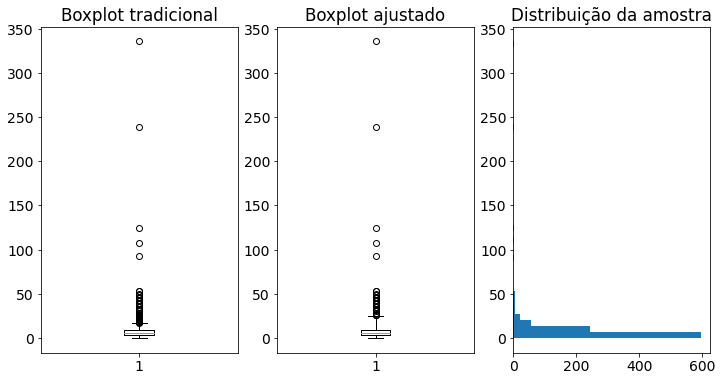

In [155]:
#Boxplot ajustado
fig4, ax4 = plt.subplots(figsize=(12, 6), ncols=3, nrows=1)

ax4[0].boxplot(cases_month_dist)
ax4[1].boxplot(cases_month_dist, whis=[0, 97])
ax4[2].hist(cases_month_dist, bins=50, orientation='horizontal')

ax4[0].set_title('Boxplot tradicional')
ax4[1].set_title('Boxplot ajustado')
ax4[2].set_title('Distribuição da amostra')

fig4.show()

In [156]:
df_jun_21.sort_values(by=['casos/1k'], ascending=False).head(20)

,bairro_codigo,bairro,rpa,microrregiao,bairro_nome,geometry,pop,casos,casos/1k
68,19,RECIFE,1,1,Recife,"POLYGON ((-34.86361 -8.04059, -34.85806 -8.046...",602,29.0,48.172757
0,728,CIDADE UNIVERSITARIA,4,3,Cidade Universitária,"POLYGON ((-34.94416 -8.04985, -34.94419 -8.050...",818,19.0,23.227384
56,94,PAISSANDU,1,2,Paissandu,"POLYGON ((-34.89525 -8.06278, -34.89491 -8.063...",507,10.0,19.723866
30,183,ROSARINHO,2,1,Rosarinho,"POLYGON ((-34.89464 -8.02834, -34.89514 -8.028...",4077,70.0,17.169487
13,159,JAQUEIRA,3,1,Jaqueira,"POLYGON ((-34.90159 -8.03691, -34.90171 -8.036...",1591,27.0,16.970459
28,140,DERBY,3,1,Derby,"POLYGON ((-34.89625 -8.05347, -34.89634 -8.053...",2071,33.0,15.934331
46,442,CASA FORTE,3,1,Casa Forte,"POLYGON ((-34.91528 -8.03154, -34.91550 -8.032...",6750,106.0,15.703704
67,27,SANTO ANTONIO,1,2,Santo Antônio,"POLYGON ((-34.87516 -8.05860, -34.87506 -8.061...",285,4.0,14.035088
92,418,GUABIRABA,3,3,Guabiraba,"POLYGON ((-35.00157 -7.92781, -35.00148 -7.927...",6330,80.0,12.638231
45,477,POCO,3,1,Poço,"POLYGON ((-34.92153 -8.02954, -34.92177 -8.030...",4615,53.0,11.484290


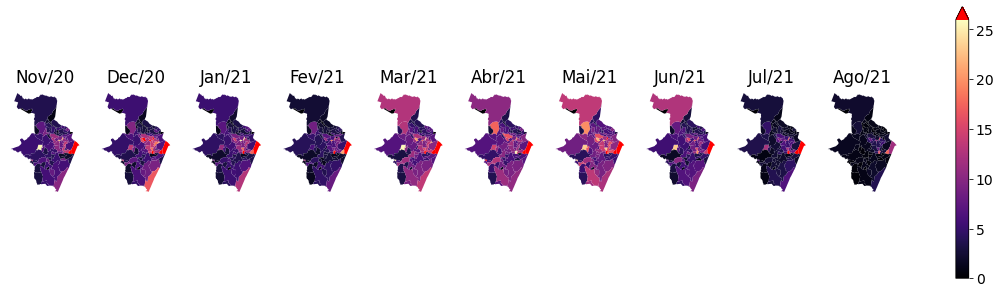

In [160]:
fig5, ax5 = plt.subplots(figsize=(20, 10), ncols=10, nrows=1, sharex=True, sharey=True)

plt.rcParams.update({'font.size': 14})

for i in range(10):
  ax5[i].axis('off')
#se você normalizar, você corrige algumas coisas, Boa viagem sempre tem muito casos, mas em proporção, é muito ou pouco?

df_nov_20.plot(ax=ax5[0], column='casos/1k', cmap='magma', linewidth=0, edgecolor='0.9', vmin=0, vmax=ub)
df_dez_20.plot(ax=ax5[1], column='casos/1k', cmap='magma', linewidth=0, edgecolor='0.9', vmin=0, vmax=ub)
df_jan_21.plot(ax=ax5[2], column='casos/1k', cmap='magma', linewidth=0, edgecolor='0.9', vmin=0, vmax=ub)
df_fev_21.plot(ax=ax5[3], column='casos/1k', cmap='magma', linewidth=0, edgecolor='0.9', vmin=0, vmax=ub)
df_mar_21.plot(ax=ax5[4], column='casos/1k', cmap='magma', linewidth=0,edgecolor='0.9', vmin=0, vmax=ub)
df_apr_21.plot(ax=ax5[5], column='casos/1k', cmap='magma', linewidth=0,edgecolor='0.9', vmin=0, vmax=ub)
df_may_21.plot(ax=ax5[6], column='casos/1k', cmap='magma', linewidth=0, edgecolor='0.9', vmin=0, vmax=ub)
df_jun_21.plot(ax=ax5[7], column='casos/1k', cmap='magma', linewidth=0, edgecolor='0.9', vmin=0, vmax=ub)
df_jul_21.plot(ax=ax5[8], column='casos/1k', cmap='magma', linewidth=0, edgecolor='0.9', vmin=0, vmax=ub)
df_aug_21.plot(ax=ax5[9], column='casos/1k', cmap='magma', linewidth=0, edgecolor='0.9', vmin=0, vmax=ub)

months = ['Nov/20', 'Dec/20', 'Jan/21', 'Fev/21', 'Mar/21', 'Abr/21', 'Mai/21', 'Jun/21', 'Jul/21', 'Ago/21']
for n, j in enumerate(months):
  ax5[n].set_title(j)


#patch_col1 = axes1[1].collections[0]
norm = Normalize(0, ub)
cmap= plt.get_cmap('magma')
cb2 = fig5.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax5, shrink=0.5, extend='max')
cb2.cmap.set_over('red')

#Bairro do Recife (erro de anotação)plt.show()

##DIstribuição de casos graves por idades no decorrer do tempo:

In [52]:
graves

,data_notificacao,sexo,idade,data_inicio_sintomas,raca,etnia,sintomas_apresentados,outros_sintomas,doencas_preexistentes,outras_doencas_preexistentes,evolucao,classificacao_final,data_obito,profissional_saude,categoria_profissional,municipio_notificacao,bairro,ds
10987,2020-03-05,Feminino,66,2020-03-01,NaN,NaN,"Febre, Tosse, Cefaleia",NaN,NaN,NaN,RECUPERADO,CONFIRMADO,NaN,NaN,NaN,RECIFE,BOA VIAGEM,VI
6013,2020-03-05,Masculino,71,2020-03-01,NaN,NaN,"Febre, Tosse, Cefaleia",NaN,Diabetes,NaN,RECUPERADO,CONFIRMADO,NaN,NaN,NaN,RECIFE,BOA VIAGEM,VI
7939,2020-03-07,Masculino,39,2020-03-06,NaN,NaN,"Febre, Tosse, Dor de Garganta, Coriza / Conges...",NaN,NaN,NaN,RECUPERADO,CONFIRMADO,NaN,SIM,Outro profissional de serviço de saúde,RECIFE,BOA VIAGEM,VI
353,2020-03-12,Masculino,68,2020-03-08,Branca,NaN,Febre,NaN,Doenças Cardíacas ou Vasculares,NaN,ÓBITO,CONFIRMADO,2020-03-26,NaN,NaN,RECIFE,PINA,VI
7961,2020-03-12,Feminino,97,2020-03-12,NaN,NaN,Febre,NaN,Doenças Renais Cronicas,DOENCA NEUROLOGICA,RECUPERADO,CONFIRMADO,NaN,NaN,NaN,RECIFE,ILHA DO RETIRO,IV
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20402,2021-09-23,Feminino,65,2021-09-20,Parda,NaN,"Dispneia, Desconforto respiratório / aperto to...",NaN,Doenças Cardíacas ou Vasculares,NaN,INTERNADO LEITO DE ISOLAMENTO,CONFIRMADO,NaN,NÃO,NaN,RECIFE,ALTO JOSE BONIFACIO,VII
27359,2021-09-23,Masculino,38,2021-09-19,Parda,NaN,"Febre, Tosse, Dispneia, Dor de Garganta, Coriz...",ODINOFAGIA,NaN,NaN,INTERNADO LEITO DE ISOLAMENTO,CONFIRMADO,NaN,NÃO,NaN,RECIFE,BOA VISTA,I
3299,2021-09-24,Feminino,54,2021-05-06,Branca,NaN,"Febre, Tosse, Dispneia, Saturação O2 < 95",NaN,"Doenças Cardíacas ou Vasculares, Diabetes",HAS CARDIOPATIA,ÓBITO,CONFIRMADO,2021-05-10,NÃO,NaN,RECIFE,CORDEIRO,IV
16947,2021-09-24,Feminino,71,2021-03-22,Branca,NaN,"Febre, Dispneia, Desconforto respiratório / ap...",DESORIENTADA,Doenças Cardíacas ou Vasculares,NaN,ÓBITO,CONFIRMADO,2021-03-30,NÃO,NaN,RECIFE,AREIAS,V


In [53]:
graves.idade.unique() #é um object então você pode tratar como string

array(['66', '71', '39', '68', '97', '58', '60', '28', '40', '54', '63',
       '30', '16', '67', '25', '74', '31', '46', '69', '51', '56', '45',
       '59', '53', '36', '42', '26', '34', '49', '41', '32', '35', '38',
       '23', '37', '33', '27', '85', '65', '5', '70', '75', '52', '82',
       '64', '48', '24', '62', '72', '80', '50', '47', '44', '73', '92',
       '57', '29', '61', '55', '87', '88', '43', '90', '3 meses', '95',
       '78', '83', '18', '77', '15', '86', '22', '93', '84', '21', '81',
       '76', '0 meses', '89', '4', '94', '10', '17', '102', '99',
       '8 meses', '5 meses', '79', '14', '9', '91', '13', '20', '96',
       '19', '98', '6 meses', '11', '8', '1', '2', '1 mês', '10 meses',
       '7', '101', '6', '12', '3', '2 meses', '7 meses', '100', '103',
       '0', '4 meses', '104', '9 meses', '11 meses', '114', '106', '105'],
      dtype=object)

In [54]:
11/12

0.9166666666666666

In [66]:
for age in list(graves.idade.unique()): #Nomalizando os meses em unidade anos, de forma que consiga convertê-los para int depois
  if 'meses' in age:
    print(round(int(age.strip('meses'))/12, 2))
    

0.25
0.0
0.67
0.42
0.5
0.83
0.17
0.58
0.33
0.75
0.92


In [46]:
graves.iloc[0]

data_notificacao                   2020-03-05 00:00:00
sexo                                          Feminino
idade                                               66
data_inicio_sintomas                        2020-03-01
raca                                               NaN
etnia                                              NaN
sintomas_apresentados           Febre, Tosse, Cefaleia
outros_sintomas                                    NaN
doencas_preexistentes                              NaN
outras_doencas_preexistentes                       NaN
evolucao                                    RECUPERADO
classificacao_final                         CONFIRMADO
data_obito                                         NaN
profissional_saude                                 NaN
categoria_profissional                             NaN
municipio_notificacao                           RECIFE
bairro                                      BOA VIAGEM
ds                                                  VI
Name: 1098

In [58]:
graves.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16126 entries, 10987 to 10127
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   data_notificacao              16126 non-null  datetime64[ns]
 1   sexo                          16126 non-null  object        
 2   idade                         16126 non-null  object        
 3   data_inicio_sintomas          15794 non-null  object        
 4   raca                          12633 non-null  object        
 5   etnia                         1 non-null      object        
 6   sintomas_apresentados         15113 non-null  object        
 7   outros_sintomas               2761 non-null   object        
 8   doencas_preexistentes         6106 non-null   object        
 9   outras_doencas_preexistentes  3391 non-null   object        
 10  evolucao                      16126 non-null  object        
 11  classificacao_final     

In [69]:
for i in range(len(graves)):
  if 'meses' in graves.iloc[i]['idade']:
    graves.iloc[i]['idade'] = round(int(graves.iloc[i]['idade'].strip('meses')) / 12, 2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [70]:
graves.idade.unique()

array(['66', '71', '39', '68', '97', '58', '60', '28', '40', '54', '63',
       '30', '16', '67', '25', '74', '31', '46', '69', '51', '56', '45',
       '59', '53', '36', '42', '26', '34', '49', '41', '32', '35', '38',
       '23', '37', '33', '27', '85', '65', '5', '70', '75', '52', '82',
       '64', '48', '24', '62', '72', '80', '50', '47', '44', '73', '92',
       '57', '29', '61', '55', '87', '88', '43', '90', '3 meses', '95',
       '78', '83', '18', '77', '15', '86', '22', '93', '84', '21', '81',
       '76', '0 meses', '89', '4', '94', '10', '17', '102', '99',
       '8 meses', '5 meses', '79', '14', '9', '91', '13', '20', '96',
       '19', '98', '6 meses', '11', '8', '1', '2', '1 mês', '10 meses',
       '7', '101', '6', '12', '3', '2 meses', '7 meses', '100', '103',
       '0', '4 meses', '104', '9 meses', '11 meses', '114', '106', '105'],
      dtype=object)

In [71]:
for i in range(len(df_of)):
  if df_of.iloc[i]['idade'] == '1 mês':
    df_of.iloc[i]['idade']  = '0.08'

NameError: ignored

In [ ]:
graves[graves['idade'] ==  '1 mês']

,data_notificacao,sexo,idade,data_inicio_sintomas,raca,etnia,sintomas_apresentados,outros_sintomas,doencas_preexistentes,outras_doencas_preexistentes,evolucao,classificacao_final,data_obito,profissional_saude,categoria_profissional,municipio_notificacao,bairro,ds


In [ ]:
graves.idade.unique()

array(['78', '34', '61', '69', '93', '57', '80', '46', '75', '30', '67',
       '79', '53', '73', '45', '81', '86', '48', '36', '71', '70', '1',
       '35', '56', '88', '37', '60', '52', '58', '54', '83', '47', '65',
       '62', '55', '43', '39', '72', '77', '87', '90', '84', '66', '74',
       '76', '89', '31', '82', '0', '49', '85', '33', '29', '59', '41',
       '51', '50', '63', '64', '44', '42', '40', '101', '28', '8', '38',
       '92', '68', '22', '25', '21', '26', '32', '23', '24', '96', '95',
       '27', '5', '17', '91', '99', '20', '0.08', 0.25, '10', '16', '15',
       '7', '100', '98', '2', '18', '94', '9', '6', '106', '19', '102',
       0.58, 0.0, '4', '3', '97', 0.33, 0.92, 0.17, '105', 0.75, '14',
       '11', '13', 0.67, '12', 0.83, '104', '114', '103', 0.5, 0.42],
      dtype=object)

In [ ]:
graves['idade'] = pd.to_numeric(graves['idade'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
max(gravesf['idade'])

114.0

In [ ]:
graves = graves.set_index(['data_notificacao'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
graves.sort_values(by=['data_notificacao'], inplace=True)

In [ ]:
graves

,sexo,idade,data_inicio_sintomas,raca,etnia,sintomas_apresentados,outros_sintomas,doencas_preexistentes,outras_doencas_preexistentes,evolucao,classificacao_final,data_obito,profissional_saude,categoria_profissional,municipio_notificacao,bairro,ds
data_notificacao,,,,,,,,,,,,,,,,,
2020-03-05,Masculino,71.0,2020-03-01,NaN,NaN,"Febre, Tosse, Cefaleia",NaN,Diabetes,NaN,RECUPERADO,CONFIRMADO,NaN,NaN,NaN,RECIFE,BOA VIAGEM,VI
2020-03-05,Feminino,66.0,2020-03-01,NaN,NaN,"Febre, Tosse, Cefaleia",NaN,NaN,NaN,RECUPERADO,CONFIRMADO,NaN,NaN,NaN,RECIFE,BOA VIAGEM,VI
2020-03-07,Masculino,39.0,2020-03-06,NaN,NaN,"Febre, Tosse, Dor de Garganta, Coriza / Conges...",NaN,NaN,NaN,RECUPERADO,CONFIRMADO,NaN,SIM,Outro profissional de serviço de saúde,RECIFE,BOA VIAGEM,VI
2020-03-12,Masculino,68.0,2020-03-08,Branca,NaN,Febre,NaN,Doenças Cardíacas ou Vasculares,NaN,ÓBITO,CONFIRMADO,2020-03-26,NaN,NaN,RECIFE,PINA,VI
2020-03-12,Feminino,58.0,2020-03-10,NaN,NaN,Tosse,NaN,Doenças Cardíacas ou Vasculares,NaN,RECUPERADO,CONFIRMADO,NaN,NaN,NaN,RECIFE,PINA,VI
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-23,Feminino,65.0,2021-09-20,Parda,NaN,"Dispneia, Desconforto respiratório / aperto to...",NaN,Doenças Cardíacas ou Vasculares,NaN,INTERNADO LEITO DE ISOLAMENTO,CONFIRMADO,NaN,NÃO,NaN,RECIFE,ALTO JOSE BONIFACIO,VII
2021-09-23,Masculino,38.0,2021-09-19,Parda,NaN,"Febre, Tosse, Dispneia, Dor de Garganta, Coriz...",ODINOFAGIA,NaN,NaN,INTERNADO LEITO DE ISOLAMENTO,CONFIRMADO,NaN,NÃO,NaN,RECIFE,BOA VISTA,I
2021-09-24,Feminino,71.0,2021-03-22,Branca,NaN,"Febre, Dispneia, Desconforto respiratório / ap...",DESORIENTADA,Doenças Cardíacas ou Vasculares,NaN,ÓBITO,CONFIRMADO,2021-03-30,NÃO,NaN,RECIFE,AREIAS,V


In [ ]:
graves.bairro.value_counts().head(10)

BOA VIAGEM      1530
VARZEA           643
IBURA            584
COHAB            538
IPUTINGA         512
IMBIRIBEIRA      491
CASA AMARELA     441
CORDEIRO         426
AGUA FRIA        401
SANTO AMARO      351
Name: bairro, dtype: int64

In [ ]:
df_of.loc['2021-03']['idade']

data_notificacao
2021-03-01     86.0
2021-03-01     70.0
2021-03-01     60.0
2021-03-01     46.0
2021-03-01    102.0
              ...  
2021-03-31     32.0
2021-03-31     68.0
2021-03-31     36.0
2021-03-31     62.0
2021-03-31     45.0
Name: idade, Length: 1211, dtype: float64

In [ ]:
bins = pd.IntervalIndex.from_tuples(data=[(0,9), (10,19), (20, 29), (30,39), (40, 49), (50, 59), (60, 69), (70, 79), (80, 89), (90, 99), (100, np.inf)], closed="both")
#bins inspiradas nas classes usadas no site PE CONTRA CORONAVIRUS
[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 114]

In [ ]:
df_of.loc['2020-03']['idade']

data_notificacao
2020-03-05    71.0
2020-03-05    66.0
2020-03-07    39.0
2020-03-12    68.0
2020-03-12    58.0
              ... 
2020-03-31    71.0
2020-03-31    59.0
2020-03-31    83.0
2020-03-31    77.0
2020-03-31    44.0
Name: idade, Length: 186, dtype: float64

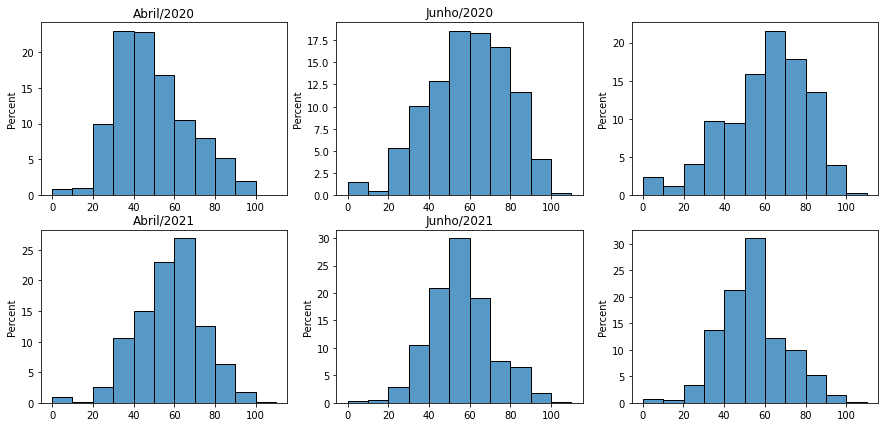

In [ ]:
fig4, ax4 = plt.subplots(figsize=(15, 7), nrows=2, ncols=3)

months_2 = ['2020-03', '2020-04', '2020-05', '2020-06', '2020-12']
sns.histplot(x=list(graves['2020-04']['idade']), ax=ax4[0][0], stat='percent', binwidth=10)
sns.histplot(x=list(gaves['2021-04']['idade']), ax=ax4[1][0], stat='percent', binwidth=10)

sns.histplot(x=list(graves['2020-05']['idade']), ax=a4[0][1], stat='percent', binwidth=10)
sns.histplot(x=list(graves['2021-05']['idade']), ax=ax3[1][1], stat='percent', binwidth=10)


sns.histplot(x=list(graves['2020-06']['idade']),ax=ax4[0][2], binwidth=10, stat='percent')
sns.histplot(x=list(graves['2021-06']['idade']),ax=ax4[1][2], binwidth=10, stat='percent')


ax4[0][0].set_title('Abril/2020')
ax4[1][0].set_title('Abril/2021')
ax4[0][1].set_title('Junho/2020')
ax4[1][1].set_title('Junho/2021')
plt.show()

#Profissionais de saúde (abril de 2020)(ver quem são estes)

In [ ]:
months_2 = ['2020-04', '2021-04', '2020-05', '2021-05','2020-06', '2021-06']
for i in months_2:
  print(df_of[i]['idade'].mean())

48.74643912926632
57.44910562180579
58.98229363579079
55.41376785714286
60.1335595105673
54.508763769889846


###Genomic data

In [ ]:
genomes = pd.read_csv("/content/gisaid_hcov-19_2021_11_23_02.tsv", sep='\t')

In [ ]:
genomes

,Virus name,Accession ID,Collection date,Location,Host,Additional location information,Sampling strategy,Gender,Patient age,Patient status,Last vaccinated,Passage,Specimen,Additional host information,Lineage,Clade,AA Substitutions
0,hCoV-19/Brazil/PE-UFPE053/2020,EPI_ISL_1117383,2020-06-02,South America / Brazil / Pernambuco / Recife,Human,NaN,NaN,Male,28,unknown,NaN,Original,Nasopharyngeal swab,NaN,B.1.1,GR,"(N_R203K,M_E167Q,N_G204R,NSP12_A379S,NSP12_P32..."
1,hCoV-19/Brazil/PE-UFPE051/2020,EPI_ISL_1117407,2020-06-02,South America / Brazil / Pernambuco / Recife,Human,NaN,NaN,Male,43,unknown,NaN,Original,Nasopharyngeal swab,NaN,B.1.1,GR,"(NSP15_A92V,N_R203K,N_G204R,NSP12_P323L,Spike_..."
2,hCoV-19/Brazil/PE-UFPE052/2020,EPI_ISL_1117408,2020-06-02,South America / Brazil / Pernambuco / Recife,Human,NaN,NaN,Male,50,unknown,NaN,Original,Nasopharyngeal swab,NaN,B.1.1.28,GR,"(NSP1_R24C,N_R203K,N_G204R,NSP12_P323L,Spike_D..."
3,hCoV-19/Brazil/PE-UFPE054/2020,EPI_ISL_1117409,2020-06-02,South America / Brazil / Pernambuco / Recife,Human,NaN,NaN,Female,71,unknown,NaN,Original,Nasopharyngeal swab,NaN,B.1.1,GR,"(N_R203K,N_G204R,NSP12_P323L,Spike_D614G)"
4,hCoV-19/Brazil/PE-UFPE055/2020,EPI_ISL_1117410,2020-06-02,South America / Brazil / Pernambuco / Recife,Human,NaN,NaN,Female,71,unknown,NaN,Original,Nasopharyngeal swab,NaN,B.1.1.277,GR,"(N_R203K,N_G204R,NS8_V62M,NSP12_P323L,Spike_D6..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
304,hCoV-19/Brazil/PE-FIOCRUZ-IAM5173/2021,EPI_ISL_6573886,2021-10-11,South America / Brazil / Pernambuco / Recife,Human,NaN,NaN,Female,38,unknown,NaN,Original,NaN,NaN,AY.99.2,GK,"(N_G215C,N_D63G,N_R203M,NSP8_T145I,NSP12_G671S..."
305,hCoV-19/Brazil/PE-FIOCRUZ-IAM4976/2021,EPI_ISL_6573889,2021-10-08,South America / Brazil / Pernambuco / Recife,Human,NaN,NaN,Male,48,unknown,NaN,Original,NaN,NaN,AY.99.2,GK,"(N_G215C,N_D63G,N_R203M,NSP8_T145I,NSP12_G671S..."
306,hCoV-19/Brazil/PE-FIOCRUZ-IAM4981/2021,EPI_ISL_6573912,2021-10-04,South America / Brazil / Pernambuco / Recife,Human,NaN,NaN,Female,48,unknown,NaN,Original,NaN,NaN,AY.99.2,GK,"(N_G215C,N_D63G,N_R203M,NSP8_T145I,NSP12_G671S..."
307,hCoV-19/Brazil/PE-FIOCRUZ-IAM4978/2021,EPI_ISL_6573958,2021-10-07,South America / Brazil / Pernambuco / Recife,Human,NaN,NaN,Female,41,unknown,NaN,Original,NaN,NaN,AY.99.2,GK,"(N_G215C,N_D63G,N_R203M,NSP8_T145I,NSP12_G671S..."


In [ ]:
genomes.Lineage.value_counts()

P.1          121
AY.99.2       76
B.1.1         56
P.1.7         11
P.2            8
B.1.1.28       5
P.1.12         4
B.1.617.2      4
B.1.1.33       4
P.1.4          3
B.1.212        2
P.1.14         2
AY.101         2
P.1.15         2
AY.100         1
AY.102         1
N.9            1
None           1
B.1.1.16       1
B.1.1.277      1
B              1
AY.117         1
B.1.1.117      1
Name: Lineage, dtype: int64

In [ ]:
genomes['Collection date'] = pd.DatetimeIndex(genomes['Collection date'])
genomes = genomes.set_index(['Collection date'])
genomes.sort_values(by=['Collection date'], inplace=True)

In [ ]:
genomes

,Virus name,Accession ID,Location,Host,Additional location information,Sampling strategy,Gender,Patient age,Patient status,Last vaccinated,Passage,Specimen,Additional host information,Lineage,Clade,AA Substitutions
Collection date,,,,,,,,,,,,,,,,
2020-04-07,hCoV-19/Brazil/PE-FIOCRUZ-IAM08/2020,EPI_ISL_500460,South America / Brazil / Pernambuco / Recife,Human,NaN,NaN,Female,unknown,unknown,NaN,Original,NaN,NaN,B.1.1.117,GR,"(N_R203K,N_G204R,NSP12_P323L,Spike_D614G,Spike..."
2020-04-07,hCoV-19/Brazil/PE-FIOCRUZ-IAM10/2020,EPI_ISL_500461,South America / Brazil / Pernambuco / Recife,Human,NaN,NaN,Female,unknown,unknown,NaN,Original,NaN,NaN,B.1.1,GR,"(N_R203K,N_G204R,NSP12_P323L,Spike_D614G,NSP12..."
2020-04-07,hCoV-19/Brazil/PE-FIOCRUZ-IAM16/2020,EPI_ISL_500865,South America / Brazil / Pernambuco / Recife,Human,NaN,NaN,Male,80,unknown,NaN,Original,NaN,NaN,B.1.1,GR,"(NSP12_T394M,N_R203K,N_G204R,NSP12_P323L,Spike..."
2020-04-07,hCoV-19/Brazil/PE-FIOCRUZ-IAM17/2020,EPI_ISL_500866,South America / Brazil / Pernambuco / Recife,Human,NaN,NaN,Female,31,unknown,NaN,Original,NaN,NaN,B.1.1,GR,"(N_R203K,NSP12_A382V,N_G204R,Spike_H207Q,NSP12..."
2020-04-07,hCoV-19/Brazil/PE-FIOCRUZ-IAM19/2020,EPI_ISL_500467,South America / Brazil / Pernambuco / Recife,Human,NaN,NaN,Female,unknown,unknown,NaN,Original,NaN,NaN,B.1.212,G,"(NSP3_G908S,NSP3_M1436I,NSP13_E261D,Spike_N501..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-11,hCoV-19/Brazil/PE-FIOCRUZ-IAM5173/2021,EPI_ISL_6573886,South America / Brazil / Pernambuco / Recife,Human,NaN,NaN,Female,38,unknown,NaN,Original,NaN,NaN,AY.99.2,GK,"(N_G215C,N_D63G,N_R203M,NSP8_T145I,NSP12_G671S..."
2021-10-14,hCoV-19/Brazil/PE-FIOCRUZ-IAM5184/2021,EPI_ISL_6573652,South America / Brazil / Pernambuco / Recife,Human,NaN,NaN,Female,53,unknown,NaN,Original,NaN,NaN,AY.99.2,GK,"(N_G215C,N_D63G,N_R203M,NSP8_T145I,NSP12_G671S..."
2021-10-14,hCoV-19/Brazil/PE-FIOCRUZ-IAM5178/2021,EPI_ISL_6573651,South America / Brazil / Pernambuco / Recife,Human,NaN,NaN,Female,47,unknown,NaN,Original,NaN,NaN,AY.99.2,GK,"(N_G215C,N_D63G,N_R203M,NSP8_T145I,NSP12_G671S..."


In [ ]:
genomes.loc['2021-02']['Lineage'].value_counts()

P.1       8
P.2       1
P.1.12    1
Name: Lineage, dtype: int64